# Activation-based Style Vectors for Yelp Dataset

### Notebook Overview
This notebook demonstrates **activation-based style vector steering** using the Yelp sentiment dataset.  
We will:
- Extract hidden activations for positive vs negative reviews
- Compute style vectors (`mean_pos - mean_neg`)
- Inject these vectors into GPT Neo 1.3B during generation
- Evaluate sentiment shift and fluency on factual and subjective prompts


In [ ]:
!pip install -q transformers datasets torch tqdm nbformat accelerate

In [ ]:
import random, numpy as np, torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification
from datasets import load_dataset
from tqdm import tqdm
import pandas as pd
import urllib
from datasets import DatasetDict, Dataset
from functools import partial
import os
from transformers import AutoModel
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

In [ ]:
CONFIG = {
    'model_name': 'EleutherAI/gpt-neo-1.3B',
    'seq_len': 128,
    'batch_size': 32,
    'samples_per_class': 50000,
    'insertion_layers': list(range(12, 18)),
    'seed': 42
}
random.seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
torch.manual_seed(CONFIG['seed'])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


In [ ]:
model_name = CONFIG['model_name']
print('Loading model', model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer.pad_token = '[PAD]'
tokenizer.pad_token_id = tokenizer.convert_tokens_to_ids('[PAD]')
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
model.config.output_hidden_states = True
model.eval()

Loading model EleutherAI/gpt-neo-1.3B


GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 2048)
    (wpe): Embedding(2048, 2048)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPTNeoBlock(
        (ln_1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (out_proj): Linear(in_features=2048, out_features=2048, bias=True)
          )
        )
        (ln_2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=2048, out_features=8192, bias=True)
          (c_proj):

### Load Yelp Sentiment Dataset

In [ ]:
def load_yelp_binary():
    urls = {
        'train_0': 'https://raw.githubusercontent.com/shentianxiao/language-style-transfer/master/data/yelp/sentiment.train.0',
        'train_1': 'https://raw.githubusercontent.com/shentianxiao/language-style-transfer/master/data/yelp/sentiment.train.1',
        'test_0': 'https://raw.githubusercontent.com/shentianxiao/language-style-transfer/master/data/yelp/sentiment.test.0',
        'test_1': 'https://raw.githubusercontent.com/shentianxiao/language-style-transfer/master/data/yelp/sentiment.test.1'
    }
    data = {}
    for key, url in urls.items():
        with urllib.request.urlopen(url) as response:
            content = response.read().decode('utf-8').splitlines()
            data[key] = content
    train_texts = data['train_0'] + data['train_1']
    train_labels = [0] * len(data['train_0']) + [1] * len(data['train_1'])
    test_texts = data['test_0'] + data['test_1']
    test_labels = [0] * len(data['test_0']) + [1] * len(data['test_1'])
    return DatasetDict({
        'train': Dataset.from_dict({'text': train_texts, 'label': train_labels}),
        'test': Dataset.from_dict({'text': test_texts, 'label': test_labels})
    })

ds = load_yelp_binary()
print('Train size:', len(ds['train']), 'Test size:', len(ds['test']))

Train size: 444101 Test size: 126670


### Tokenization and Batch Streaming by Sentiment Label


In [ ]:
def tokenize_texts(texts, max_length=CONFIG['seq_len']):
    return tokenizer(texts, truncation=True, padding='max_length', max_length=max_length, return_tensors='pt', return_attention_mask=True)

def stream_texts_for_label(label_value, split='train', max_samples=1000, batch_size=8):
    subset = ds[split].filter(lambda x: x['label']==label_value)
    indices = list(range(len(subset)))
    random_state = np.random.RandomState(CONFIG['seed'])
    random_state.shuffle(indices)
    indices = indices[:max_samples]
    for i in range(0, len(indices), batch_size):
        batch_idx = indices[i:i+batch_size]
        texts = [subset[int(j)]['text'] for j in batch_idx]
        toks = tokenize_texts(texts)
        toks = {k:v.to(device) for k,v in toks.items()}
        yield toks

### Compute Mean Hidden Activations per Label

In [ ]:
def compute_layer_means_for_label(model, label_value, max_samples=1000, batch_size=8):
    model.eval()
    layer_sums = None
    total_token_count = 0
    for batch in stream_texts_for_label(label_value, 'train', max_samples=max_samples, batch_size=batch_size):
        with torch.no_grad():
            out = model(**batch, output_hidden_states=True)
            hidden_states = out.hidden_states
            attention_mask = batch['attention_mask']
            batch_tokens = attention_mask.sum().item()
            if layer_sums is None:
                layer_sums = [np.zeros(h.shape[-1], dtype=np.float64) for h in hidden_states]
            for idx, h in enumerate(hidden_states):
                masked_h = h * attention_mask.unsqueeze(-1)
                s = masked_h.detach().cpu().numpy().sum(axis=(0,1))
                layer_sums[idx] += s
            total_token_count += batch_tokens
    layer_means = [s / total_token_count for s in layer_sums]
    return layer_means

In [ ]:
batch_size = CONFIG['batch_size']
samples = CONFIG['samples_per_class']
print('Computing layer means for positive class...')
means_pos = compute_layer_means_for_label(model, label_value=1, max_samples=samples, batch_size=batch_size)
print('Computing layer means for negative class...')
means_neg = compute_layer_means_for_label(model, label_value=0, max_samples=samples, batch_size=batch_size)
style_vectors = [torch.tensor(p - n, dtype=torch.float32).to(device) for p,n in zip(means_pos, means_neg)]
print('Computed style vector for', len(style_vectors), 'layers. Hidden size example:', style_vectors[0].shape)

Computing layer means for positive class...


Filter:   0%|          | 0/444101 [00:00<?, ? examples/s]

Computing layer means for negative class...


Filter:   0%|          | 0/444101 [00:00<?, ? examples/s]

Computed style vector for 25 layers. Hidden size example: torch.Size([2048])


In [ ]:
out_dir = '/content/style_vectors'
os.makedirs(out_dir, exist_ok=True)
for i, vec in enumerate(style_vectors):
    np.save(os.path.join(out_dir, f'style_vec_layer_{i}.npy'), vec.detach().cpu().numpy())
print('Saved style vectors to', out_dir)

In [ ]:
import shutil

shutil.make_archive('/content/style_vectors_zip', 'zip', '/content/style_vectors')

'/content/style_vectors_zip.zip'

In [ ]:
out_dir = '/content/style_vectors'

style_vectors = []
files = sorted([f for f in os.listdir(out_dir) if f.startswith("style_vec_layer_") and f.endswith(".npy")],
               key=lambda x: int(x.split("_")[-1].split(".")[0]))

for fname in files:
    vec_np = np.load(os.path.join(out_dir, fname))
    vec_torch = torch.tensor(vec_np, dtype=torch.float32).to(device)
    style_vectors.append(vec_torch)

print(f"Loaded {len(style_vectors)} style vectors from {out_dir}")

Loaded 25 style vectors from /content/style_vectors


### Load Pretrained Sentiment Classifier

In [ ]:
cls_name = 'VictorSanh/roberta-base-finetuned-yelp-polarity'
cls_tok = AutoTokenizer.from_pretrained(cls_name)
cls_model = AutoModelForSequenceClassification.from_pretrained(cls_name).to(device)
cls_model.eval()

def classify_texts(texts):
    toks = cls_tok(texts, truncation=True, padding=True, return_tensors='pt').to(device)
    with torch.no_grad():
        logits = cls_model(**toks).logits
        probs = torch.nn.functional.softmax(logits, dim=-1).cpu().numpy()
    return probs[:,1]


Some weights of the model checkpoint at VictorSanh/roberta-base-finetuned-yelp-polarity were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Define Style Vector Injection Hooks for Transformer Blocks

In [ ]:
def get_block_modules(model):
    if hasattr(model, 'transformer') and hasattr(model.transformer, 'h'):
        return model.transformer.h
    raise NotImplementedError('Block modules not found for this model type')

blocks = get_block_modules(model)
n_blocks = len(blocks)
print('Number of transformer blocks:', n_blocks)

def pick_insertion_layer_indices(spec='last4'):
    if isinstance(spec, list):
        return spec
    if spec == 'last4':
        return list(range(n_blocks-4, n_blocks))
    if spec == 'last2':
        return list(range(n_blocks-2, n_blocks))
    if spec == 'all':
        return list(range(n_blocks))
    raise ValueError('Unknown insertion spec')

insertion_indices = pick_insertion_layer_indices(CONFIG['insertion_layers'])
print('Using insertion indices:', insertion_indices)

hooks = []
def make_hook(vec, scale, layer_idx):
    def hook_fn(module, input, output):
        hidden_states = output[0]
        modification = scale * vec.view(1, 1, -1)
        modified_states = hidden_states + modification
        return modified_states
    return hook_fn

def register_hooks_for_style(style_vectors, indices, scale=1.0):
    global hooks
    remove_hooks()
    for i in indices:
        vec = style_vectors[i+1] if len(style_vectors) == (n_blocks+1) else style_vectors[i]
        target_block = blocks[i]
        h = target_block.mlp.register_forward_hook(make_hook(vec, scale, i))
        hooks.append(h)
    return hooks

def remove_hooks():
    global hooks
    for h in hooks:
        h.remove()
    hooks.clear()

Number of transformer blocks: 24
Using insertion indices: [12, 13, 14, 15, 16, 17]


In [ ]:
def remove_prompt_from_output(prompt, output):
    if output.startswith(prompt):
        return output[len(prompt):].strip()
    return output

In [ ]:
from sentence_transformers import SentenceTransformer, util

sem_model = SentenceTransformer("all-MiniLM-L6-v2")

def semantic_similarity(a, b):
    embeddings = sem_model.encode([a, b], convert_to_tensor=True)
    return util.cos_sim(embeddings[0], embeddings[1]).item()

### Compute Text Perplexity for Grammar Evaluation

In [ ]:
def perplexity(text):
  enc = tokenizer(text, return_tensors='pt').to(device)
  with torch.no_grad():
    out = model(**enc, labels=enc.input_ids)
  return math.exp(out.loss.item())

### Rewrite Text with Style Vector Steering and Evaluate

In [ ]:
def rewrite_with_style(neutral_sentence, scale=5.0, max_new_tokens=80):
  toks = tokenizer(neutral_sentence, return_tensors='pt', padding=True, truncation=True)
  input_ids = toks.input_ids.to(device)
  attention_mask = toks.attention_mask.to(device)


  with torch.no_grad():
    out_base = model.generate(
      input_ids,
      attention_mask=attention_mask,
      max_new_tokens=max_new_tokens,
      do_sample=True,
      top_p=0.9,
      top_k=40,
      pad_token_id=tokenizer.eos_token_id
    )
  baseline_text = tokenizer.decode(out_base[0], skip_special_tokens=True)


  register_hooks_for_style(style_vectors, insertion_indices, scale=scale)
  with torch.no_grad():
    out_steer = model.generate(
      input_ids,
      attention_mask=attention_mask,
      max_new_tokens=max_new_tokens,
      do_sample=True,
      top_p=0.9,
      top_k=40,
      pad_token_id=tokenizer.eos_token_id
    )
  remove_hooks()
  steered_text = tokenizer.decode(out_steer[0], skip_special_tokens=True)


  base_sent = classify_texts([baseline_text])[0]
  steer_sent = classify_texts([steered_text])[0]
  ppl = perplexity(steered_text)

  baseline_text_clean = remove_prompt_from_output(neutral_sentence, baseline_text)
  steered_text_clean = remove_prompt_from_output(neutral_sentence, steered_text)

  base_sem_sim = semantic_similarity(neutral_sentence, baseline_text_clean)
  steer_sem_sim = semantic_similarity(neutral_sentence, steered_text_clean)


  return {
      'baseline': baseline_text,
      'steered': steered_text,
      'baseline_sentiment': base_sent,
      'steered_sentiment': steer_sent,
      'baseline_semantic': base_sem_sim,
      'steered_semantic': steer_sem_sim,
      'perplexity': ppl
  }

### Example

In [ ]:
neutral = "Describe a fictional character."
result = rewrite_with_style(neutral, scale=0.3)

print("Neutral Input:")
print(neutral)
print("-" * 40)

print("Baseline Output:")
print(result['baseline'])
print("-" * 40)

print("Steered Output:")
print(result['steered'])
print("-" * 40)

print("Baseline Sentiment:")
print(f"{result['baseline_sentiment']:.4f}")
print("-" * 40)

print("Steered Sentiment:")
print(f"{result['steered_sentiment']:.4f}")
print("-" * 40)

print("Steered Perplexity:")
print(f"{result['perplexity']:.4f}")
print("-" * 40)


Neutral Input:
Describe a fictional character.
----------------------------------------
Baseline Output:
Describe a fictional character. Describe a real person that you feel could be described by the name or title of the book.

Fictional Characters

Characters

Fictional characters are fictional beings with distinct characteristics and personalities. A character can be someone, or something that is not human.

Personas

Characteristics

Fictional characters have the same characteristics as human beings. When you use the
----------------------------------------
Steered Output:
Describe a fictional character. Describe the qualities, traits, strengths, and

characterization that distinguish him or her from the readers.

1.1.2.3. Characteristics

1.1.2.3.1. Strong family values, good values in life, etc.

1.1.2.3.2. Self-awareness.

1.1.
----------------------------------------
Baseline Sentiment:
0.8618
----------------------------------------
Steered Sentiment:
0.9729
-------------------

### Run Style Steering on Prompts

In [ ]:
def run_eval(prompts, scale=5.0, max_new_tokens=80):
    results = []
    for p in tqdm(prompts, desc="Evaluating prompts"):
        res = rewrite_with_style(p, scale=scale, max_new_tokens=max_new_tokens)
        results.append({
            'prompt': p,
            'baseline_sentiment': res['baseline_sentiment'],
            'steered_sentiment': res['steered_sentiment'],
            'baseline_perplexity': perplexity(res['baseline']),
            'steered_perplexity': res['perplexity'],
            'baseline_semantic': res['baseline_semantic'],
            'steered_semantic': res['steered_semantic']
        })
    return pd.DataFrame(results)

def load_prompts():
    factual_file = "./evaluation_prompts/factual_sentences.txt"
    subjective_file = "./evaluation_prompts/subjective_sentences.txt"
    with open(factual_file, 'r') as fh:
        factual = [l.strip() for l in fh.readlines() if l.strip()]
    with open(subjective_file, 'r') as fh:
        subjective = [l.strip() for l in fh.readlines() if l.strip()]
    return factual, subjective

factual_prompts, subjective_prompts = load_prompts()

In [ ]:
df_factual = run_eval(factual_prompts, scale=0.3)
df_subjective = run_eval(subjective_prompts, scale=0.3)

Evaluating prompts: 100%|██████████| 49/49 [04:11<00:00,  5.14s/it]


In [ ]:
def plot_results(df, title_prefix):
    # Sentiment
    plt.figure(figsize=(12,5))
    plt.plot(df.index, df['baseline_sentiment'], label='Baseline Sentiment', marker='o')
    plt.plot(df.index, df['steered_sentiment'], label='Steered Sentiment', marker='o')
    plt.title(f"{title_prefix}: Sentiment Shift")
    plt.xlabel("Prompt Index")
    plt.ylabel("Positive Sentiment Probability")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Perplexity
    plt.figure(figsize=(12,5))
    plt.plot(df.index, df['baseline_perplexity'], label='Baseline PPL', marker='o')
    plt.plot(df.index, df['steered_perplexity'], label='Steered PPL', marker='o')
    plt.title(f"{title_prefix}: Perplexity")
    plt.xlabel("Prompt Index")
    plt.ylabel("Perplexity")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Semantic Similarity
    plt.figure(figsize=(12,5))
    plt.plot(df.index, df['baseline_semantic'], label='Baseline Semantic Similarity', marker='o')
    plt.plot(df.index, df['steered_semantic'], label='Steered Semantic Similarity', marker='o')
    plt.title(f"{title_prefix}: Semantic Similarity to Prompt")
    plt.xlabel("Prompt Index")
    plt.ylabel("Cosine Similarity")
    plt.legend()
    plt.grid(True)
    plt.show()

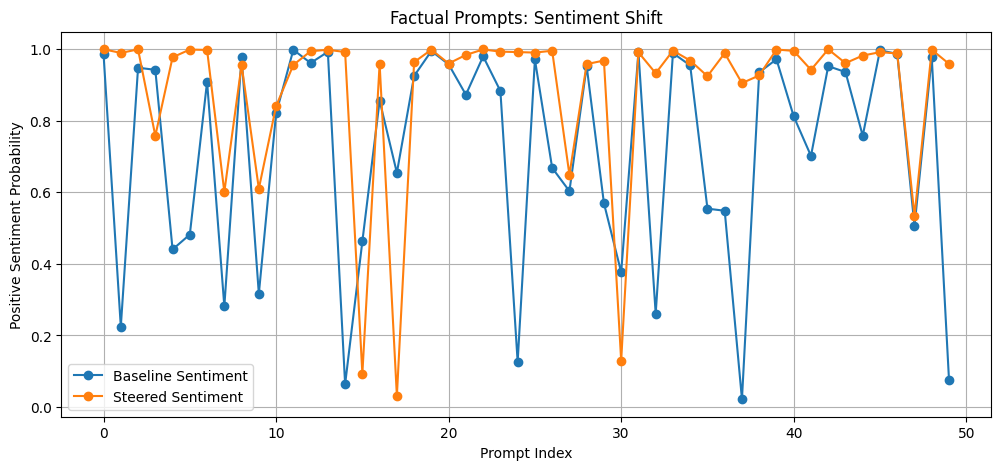

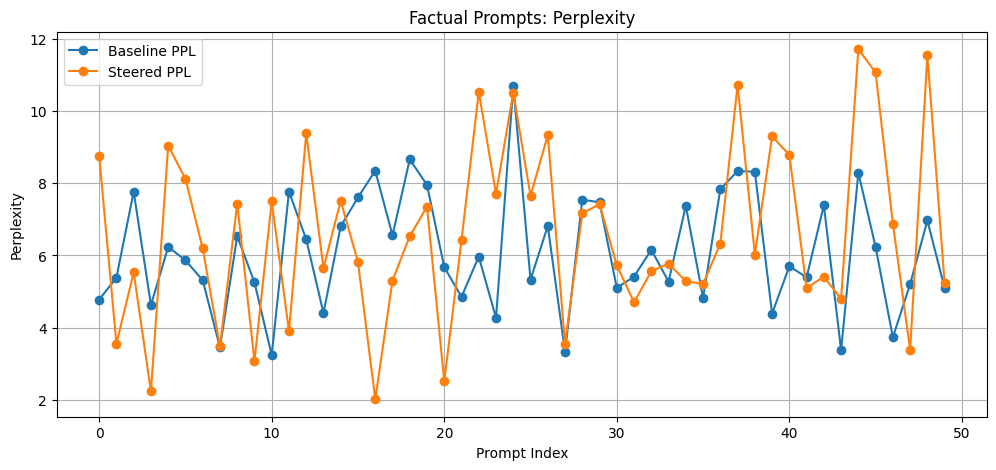

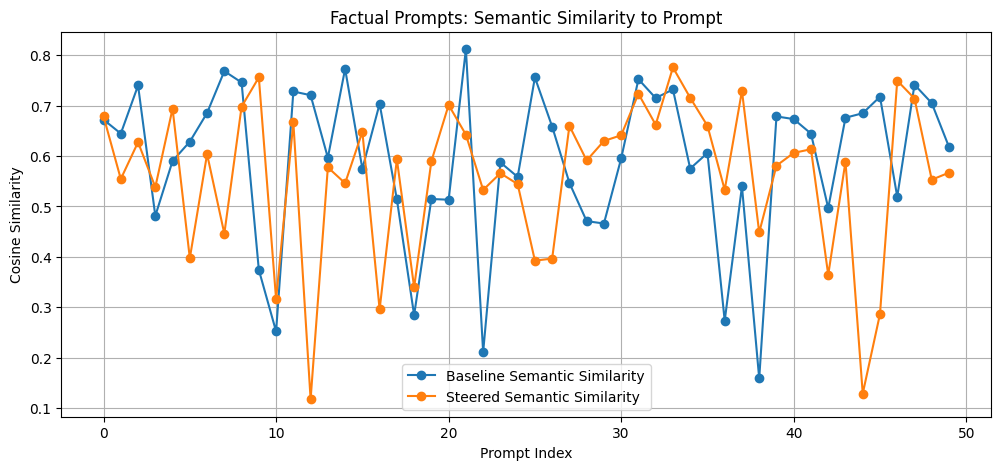

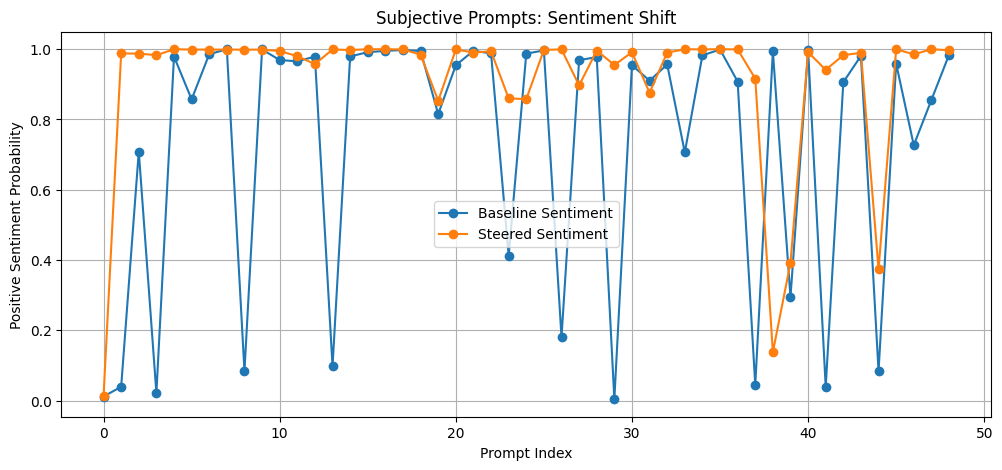

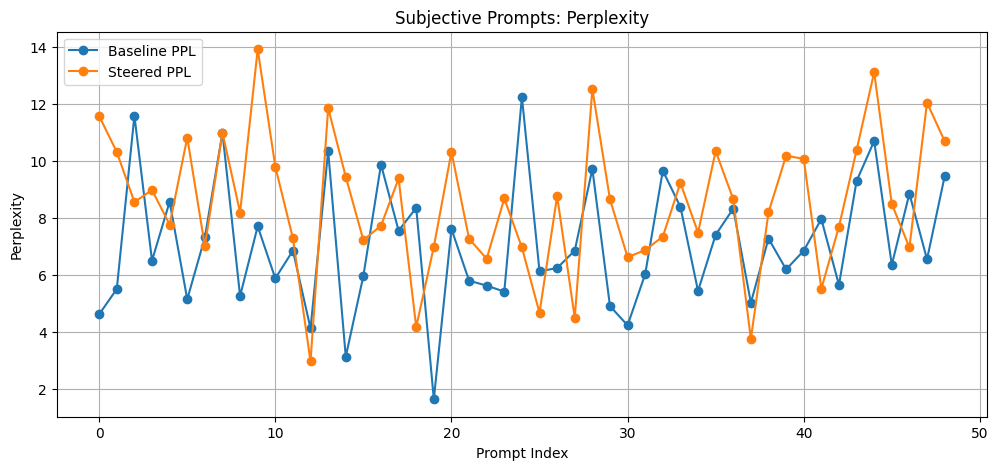

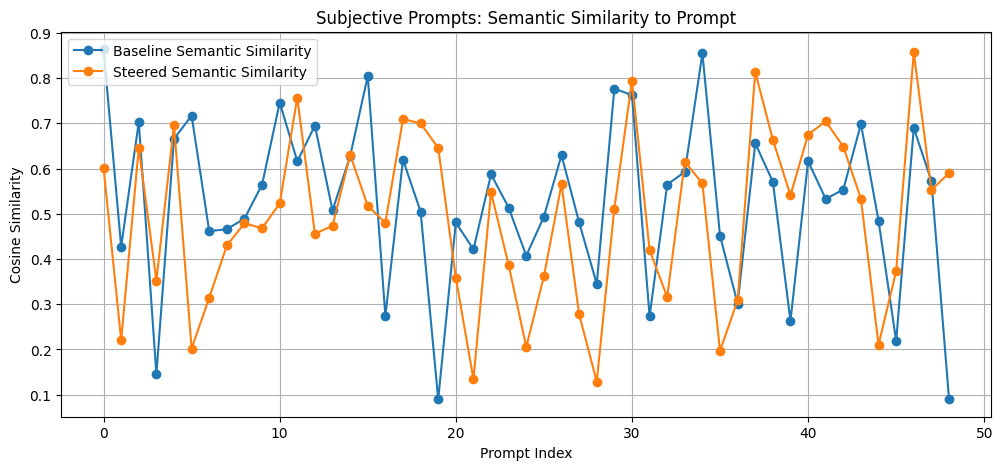

In [ ]:
plot_results(df_factual, "Factual Prompts")
plot_results(df_subjective, "Subjective Prompts")

In [ ]:
average_factual_baseline_sentiment = df_factual['baseline_sentiment'].mean()
average_factual_steered_sentiment = df_factual['steered_sentiment'].mean()
average_factual_baseline_perplexity = df_factual['baseline_perplexity'].mean()
average_factual_steered_perplexity = df_factual['steered_perplexity'].mean()
average_subjective_baseline_sentiment = df_subjective['baseline_sentiment'].mean()
average_subjective_steered_sentiment  = df_subjective['steered_sentiment'].mean()
average_subjective_baseline_perplexity = df_subjective['baseline_perplexity'].mean()
average_subjective_steered_perplexity = df_subjective['steered_perplexity'].mean()
average_factual_baseline_sem = df_factual['baseline_semantic'].mean()
average_factual_steered_sem = df_factual['steered_semantic'].mean()
average_subjective_baseline_sem = df_subjective['baseline_semantic'].mean()
average_subjective_steered_sem = df_subjective['steered_semantic'].mean()

print("Factual Sentences")
print("Average Baseline Sentiment:", average_factual_baseline_sentiment)
print("Average Steered Sentiment:", average_factual_steered_sentiment)
print("Average Baseline Perplexity:", average_factual_baseline_perplexity)
print("Average Steered Perplexity:", average_factual_steered_perplexity)
print("Average Baseline Semantic Similarity:", average_factual_baseline_sem)
print("Average Steered Semantic Similarity:", average_factual_steered_sem)

print("\nSubjective Sentences")
print("Average Baseline Sentiment:", average_subjective_baseline_sentiment)
print("Average Steered Sentiment:", average_subjective_steered_sentiment)
print("Average Baseline Perplexity:", average_subjective_baseline_perplexity)
print("Average Steered Perplexity:", average_subjective_steered_perplexity)
print("Average Baseline Semantic Similarity:", average_subjective_baseline_sem)
print("Average Steered Semantic Similarity:", average_subjective_steered_sem)

Factual Sentences
Average Baseline Sentiment: 0.72244966
Average Steered Sentiment: 0.8862176
Average Baseline Perplexity: 6.107716787069688
Average Steered Perplexity: 6.594820115181083
Average Baseline Semantic Similarity: 0.5934916082024574
Average Steered Semantic Similarity: 0.5596656097471714

Subjective Sentences
Average Baseline Sentiment: 0.7390279
Average Steered Sentiment: 0.9150304
Average Baseline Perplexity: 7.088072832224753
Average Steered Perplexity: 8.525837282364497
Average Baseline Semantic Similarity: 0.5280283143629834
Average Steered Semantic Similarity: 0.4930833477754982
